# A Marte con Python usando poliastro

<img src="http://poliastro.github.io/_images/logo_text.svg" width="70%" />

## Juan Luis Cano Rodríguez <juanlu@pybonacci.org>
## 2015-11-21 PyConES 2015

### ...en 5 minutos :)

## *Warning*: This *is* rocket science!

# ¿Qué es la Astrodinámica?

> Una rama de la Mecánica (a su vez una rama de la Física) que estudia problemas prácticos acerca del movimiento de cohetes y otros vehículos en el espacio

![Rosetta's mission](rosetta.jpg)

# ¿Qué es poliastro?

> Una biblioteca de puro Python para Astrodinámica

# ¡Vamos a Marte!

![PHYTON](phyton.jpg)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
from astropy import time

/home/juanlu/.miniconda3/envs/py34/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
from poliastro import iod
from poliastro.plotting import plot
from poliastro.bodies import Sun, Earth
from poliastro.twobody import State
from poliastro import ephem

from jplephem.spk import SPK
ephem.download_kernel("de421")

File de421.bsp already exists under /home/juanlu/.poliastro


## Primero: definir la órbita

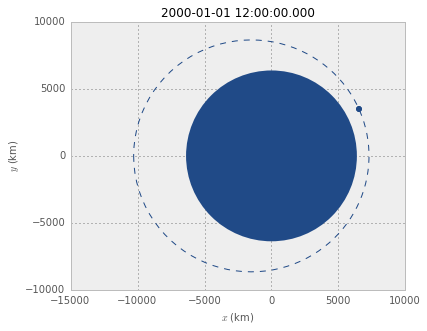

In [3]:
r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = State.from_vectors(Earth, r, v)

with plt.style.context('pybonacci'):
    plot(ss)

## Segundo: localiza los planetas

In [4]:
epoch = time.Time("2015-06-21 16:35")

r_, v_ = ephem.planet_ephem(ephem.EARTH, epoch)

In [5]:
r_

<Quantity [ -6.16897551e+04, -1.39455502e+08, -6.04805903e+07] km>

In [6]:
v_.to(u.km / u.s)

<Quantity [ 29.30832407, -0.19527688, -0.08487876] km / s>

## Tercero: Calcula la trayectoria

In [7]:
date_launch = time.Time('2011-11-26 15:02', scale='utc')
date_arrival = time.Time('2012-08-06 05:17', scale='utc')
tof = date_arrival - date_launch
r0, _ = ephem.planet_ephem(ephem.EARTH, date_launch)
r, _ = ephem.planet_ephem(ephem.MARS, date_arrival)
v0, v = iod.lambert(Sun.k, r0, r, tof)

In [8]:
v0

<Quantity [-29.29151   , 14.53326521,  5.41691331] km / s>

In [9]:
v

<Quantity [ 17.61549921,-10.99830723, -4.20796059] km / s>

### ...y es Python puro!

Truco: **numba**

![Fortran and Python](benchmark.png)

## Cuarto: ¡vamos a Marte!

In [10]:
def go_to_mars(offset=100., tof_=6000.):
    # Initial data
    N = 50

    date_launch = time.Time('2011-11-26 15:02', scale='utc')
    date_arrival = time.Time('2012-08-06 05:17', scale='utc')
    tof = tof_ * u.h

    # Calculate vector of times from launch and arrival Julian days
    jd_launch = date_launch.jd + ((offset - 100.) * u.day).value
    jd_arrival = jd_launch + tof.to(u.day).value
    jd_vec = np.linspace(jd_launch, jd_arrival, num=N)

    times_vector = time.Time(jd_vec, format='jd')
    rr_earth, vv_earth = ephem.planet_ephem(ephem.EARTH, times_vector)
    rr_mars, vv_mars = ephem.planet_ephem(ephem.MARS, times_vector)
    # Compute the transfer orbit!
    r0 = rr_earth[:, 0]
    rf = rr_mars[:, -1]

    va, vb = iod.lambert(Sun.k, r0, rf, tof)

    ss0_trans = State.from_vectors(Sun, r0, va, date_launch)
    ssf_trans = State.from_vectors(Sun, rf, vb, date_arrival)
    # Extract whole orbit of Earth, Mars and transfer (for plotting)
    rr_trans = np.zeros_like(rr_earth)
    rr_trans[:, 0] = r0
    for ii in range(1, len(jd_vec)):
        tof = (jd_vec[ii] - jd_vec[0]) * u.day
        rr_trans[:, ii] = ss0_trans.propagate(tof).r

    # Better compute backwards
    jd_init = (date_arrival - 1 * u.year).jd
    jd_vec_rest = np.linspace(jd_init, jd_launch, num=N)

    times_rest = time.Time(jd_vec_rest, format='jd')
    rr_earth_rest, _ = ephem.planet_ephem(ephem.EARTH, times_rest)
    rr_mars_rest, _ = ephem.planet_ephem(ephem.MARS, times_rest)
    # Plot figure
    # To add arrows:
    # https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/streamplot.py#L140
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    def plot_body(ax, r, color, size, border=False, **kwargs):
        """Plots body in axes object.

        """
        return ax.plot(*r[:, None], marker='o', color=color, ms=size, mew=int(border), **kwargs)

    # I like color
    color_earth0 = '#3d4cd5'
    color_earthf = '#525fd5'
    color_mars0 = '#ec3941'
    color_marsf = '#ec1f28'
    color_sun = '#ffcc00'
    color_orbit = '#888888'
    color_trans = '#444444'

    # Plotting orbits is easy!
    ax.plot(*rr_earth.to(u.km).value, color=color_earth0)
    ax.plot(*rr_mars.to(u.km).value, color=color_mars0)
    ax.plot(*rr_trans.to(u.km).value, color=color_trans)

    ax.plot(*rr_earth_rest.to(u.km).value, ls='--', color=color_orbit)
    ax.plot(*rr_mars_rest.to(u.km).value, ls='--', color=color_orbit)

    # But plotting planets feels even magical!
    plot_body(ax, np.zeros(3), color_sun, 16)

    plot_body(ax, r0.to(u.km).value, color_earth0, 8)
    plot_body(ax, rr_earth[:, -1].to(u.km).value, color_earthf, 8)

    plot_body(ax, rr_mars[:, 0].to(u.km).value, color_mars0, 8)
    plot_body(ax, rf.to(u.km).value, color_marsf, 8)

    # Add some text
    ax.text(-0.75e8, -3.5e8, -1.5e8, "MSL mission:\nfrom Earth to Mars", size=20, ha='center', va='center', bbox={"pad": 30, "lw": 0, "fc": "w"})
    ax.text(r0[0].to(u.km).value * 1.4, r0[1].to(u.km).value * 0.4, r0[2].to(u.km).value * 1.25, "Earth at launch\n(26 Nov)", ha="left", va="bottom", backgroundcolor='#ffffff')
    ax.text(rf[0].to(u.km).value * 0.7, rf[1].to(u.km).value * 1.1, rf[2].to(u.km).value, "Mars at arrival\n(6 Ago)", ha="left", va="top", backgroundcolor='#ffffff')
    ax.text(-1.9e8, 8e7, 0, "Transfer\norbit", ha="right", va="center", backgroundcolor='#ffffff')

    # Tune axes
    ax.set_xlim(-3e8, 3e8)
    ax.set_ylim(-3e8, 3e8)
    ax.set_zlim(-3e8, 3e8)

    # And finally!
    ax.view_init(30, 260)
    plt.show()
    #fig.savefig("trans_30_260.png", bbox_inches='tight')
    return fig, ax

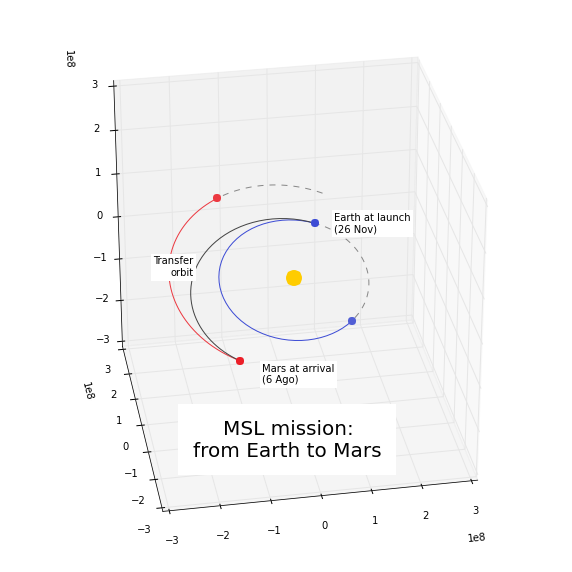

In [11]:
fig, ax = go_to_mars()

## Quinto: ¡¡Hagámoslo interactivo!!!1!

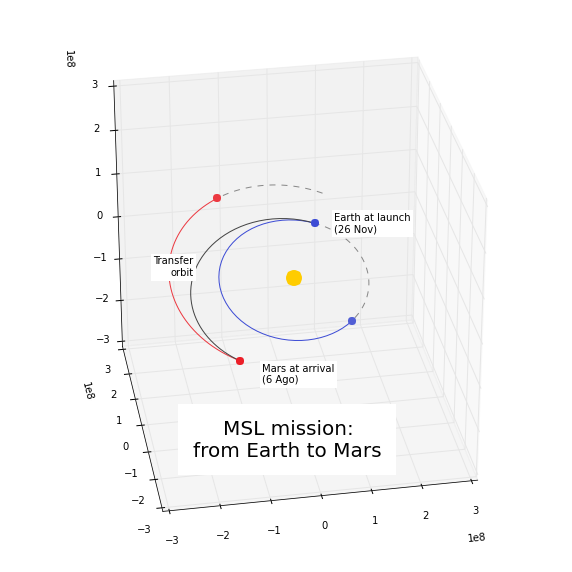

(<matplotlib.figure.Figure at 0x7f4af07533c8>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f4af0753cc0>)

In [12]:
from ipywidgets import interactive
from IPython.display import display

w = interactive(go_to_mars, offset=(100., 1000.), tof_=(100., 12000.))
display(w)

### http://poliastro.github.io

## ¡Mil gracias!

![Rocket](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2012/02/liftoff_of_vega_vv014/9659852-3-eng-GB/Liftoff_of_Vega_VV01_large.jpg)